In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
print(X_footsteps_accelerations_absolute.shape)
print(Y_footsteps_accelerations_absolute.shape)

(17248, 24)
(17248, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where FL/RR are swinging
idxs = np.where(X_footsteps_accelerations_absolute[:, -2] == 1)[0]
X_footsteps_accelerations_absolute_RR_swing = X_footsteps_accelerations_absolute[idxs]
Y_footsteps_accelerations_absolute_RR_swing = Y_footsteps_accelerations_absolute[idxs]

## Predict FL foot -> x

In [8]:
X_footsteps_accelerations_absolute_RR_swing[0, :]

array([ 0.1       ,  0.        ,  0.        ,  0.1       ,  0.        ,
        0.        ,  0.11232672, -0.02118164, -0.00713002,  0.04701474,
        0.22752666,  0.13133161, -0.3802225 ,  0.2578249 , -0.12791809,
       -0.37706181, -0.24075544,  0.12229743, -0.38356426, -0.26876706,
       -0.12459208, -0.38188431,  1.        ,  0.        ])

In [9]:
Y_footsteps_accelerations_absolute_RR_swing[0, :]

array([ 0.05770308, -0.0106103 ,  0.05375661, -0.00291052])

### Linear Regression

In [10]:
def find_best_model(X, Y, runs=1000):
    best_model = None
    lowest_error = 100
    best_Xtr, best_Xte, best_Ytr, best_Yte = None, None, None, None
    
    for _ in range(runs):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.9, shuffle=True)
        
        model = LinearRegression()
        model.fit(X_train, Y_train)

        predictions = model.predict(X_test)
        error = np.max(np.abs(predictions - Y_test))

        if error < lowest_error:
            best_model = model
            lowest_error = error
            best_Xtr, best_Xte, best_Ytr, best_Yte = X_train, X_test, Y_train, Y_test

    # Stats
    predictions = best_model.predict(best_Xte)
    print('R2: ', r2_score(predictions, best_Yte))
    print('RMSE: ', np.sqrt(mean_squared_error(best_Yte, predictions)))
    print("The lowest error is: ", np.min(np.abs(predictions - best_Yte)))
    print("The highest error is: ", np.max(np.abs(predictions - best_Yte)))
    print("The avg. error is: ", np.mean(np.abs(predictions - best_Yte)))
    
    return best_Xte, best_Yte, predictions, best_model

In [19]:
# Input
X = np.hstack((X_footsteps_accelerations_absolute_RR_swing[:, 0:1], # actual velocity
               X_footsteps_accelerations_absolute_RR_swing[:, 3:4], # referenve velocity
               X_footsteps_accelerations_absolute_RR_swing[:, 10:12], # FL position
               X_footsteps_accelerations_absolute_RR_swing[:, 13:15], # FR position
               X_footsteps_accelerations_absolute_RR_swing[:, 16:18], # RL position
               X_footsteps_accelerations_absolute_RR_swing[:, 19:21])) # RR position

# Labels
Y = np.array([Y_footsteps_accelerations_absolute_RR_swing[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split dataset and fit best model
X_test, Y_test, predictions, model_rr_relative_swinging_x = find_best_model(X, Y, runs=5000)

R2:  0.9938616695581235
RMSE:  0.014285059755141343
The lowest error is:  2.126686850305315e-05
The highest error is:  0.06121530005582032
The avg. error is:  0.01021172039568362


In [20]:
model_rr_relative_swinging_x.coef_

array([[ 0.17559615,  0.04549802, -1.19874045, -0.38572808, -0.38557009,
         0.50819631,  0.95200622, -0.01317158, -0.94395139, -0.86625187]])

In [21]:
model_rr_relative_swinging_x.intercept_

array([0.38888894])

Text(0, 0.5, 'Predictions')

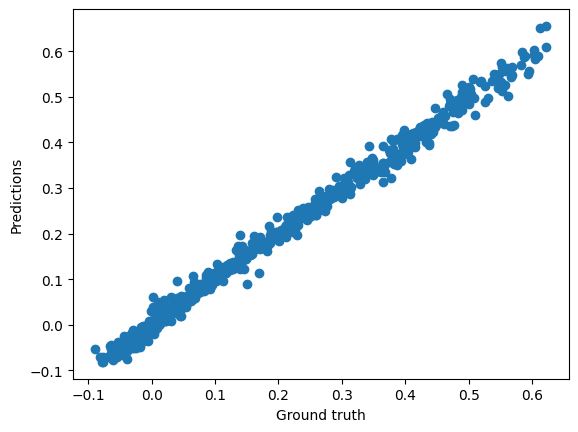

In [22]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [15]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

### Predict RR foot -> y

In [23]:
# Input
X = np.hstack((X_footsteps_accelerations_absolute_RR_swing[:, 0:1], # actual velocity
               X_footsteps_accelerations_absolute_RR_swing[:, 3:4], # referenve velocity
               X_footsteps_accelerations_absolute_RR_swing[:, 10:12], # FL position
               X_footsteps_accelerations_absolute_RR_swing[:, 13:15], # FR position
               X_footsteps_accelerations_absolute_RR_swing[:, 16:18], # RL position
               X_footsteps_accelerations_absolute_RR_swing[:, 19:21])) # RR position

# Labels
Y = np.array([Y_footsteps_accelerations_absolute_RR_swing[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split dataset and fit best model
X_test, Y_test, predictions, model_rr_relative_swinging_y = find_best_model(X, Y, runs=5000)

R2:  0.9179258799049099
RMSE:  0.007750354140109356
The lowest error is:  9.53241514001224e-06
The highest error is:  0.028463129068206056
The avg. error is:  0.005704321137120099


In [24]:
model_rr_relative_swinging_y.coef_

array([[ 0.01964554, -0.00823163,  0.10530796, -1.77063571,  0.29763862,
         0.54429097, -0.39612048,  0.21095377, -0.29572032, -0.44569658]])

In [25]:
model_rr_relative_swinging_y.intercept_

array([-0.06218682])

Text(0, 0.5, 'Predictions')

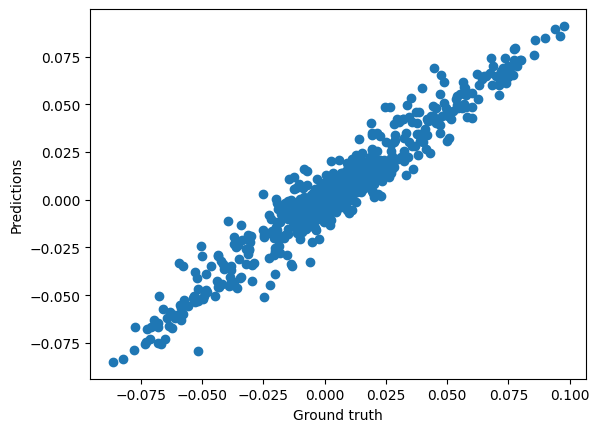

In [26]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [30]:
#for idx, prediction in enumerate(predictions):
#    print(f'Input: {X_test[idx]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')